In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import sklearn
import os
import scipy.stats as stats
import random as rn
import pandas_profiling
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from collections import Counter
from pycaret.regression import *

warnings.filterwarnings(action='ignore')

In [5]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

print(train.shape)
train.head()

(1015, 11)


,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000


In [4]:
pr = train.profile_report()
pr.to_file("./pr_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

<bound method ProfileReport.to_file of >

In [6]:
print(train.isnull().sum())
print('------------------')
print(test.isnull().sum())

id              0
title           0
odometer        0
location        0
isimported      0
engine          0
transmission    0
fuel            0
paint           0
year            0
target          0
dtype: int64
------------------
id              0
title           0
odometer        0
location        0
isimported      0
engine          0
transmission    0
fuel            0
paint           0
year            0
dtype: int64


In [7]:
df_train = train.copy()
df_test = test.copy()

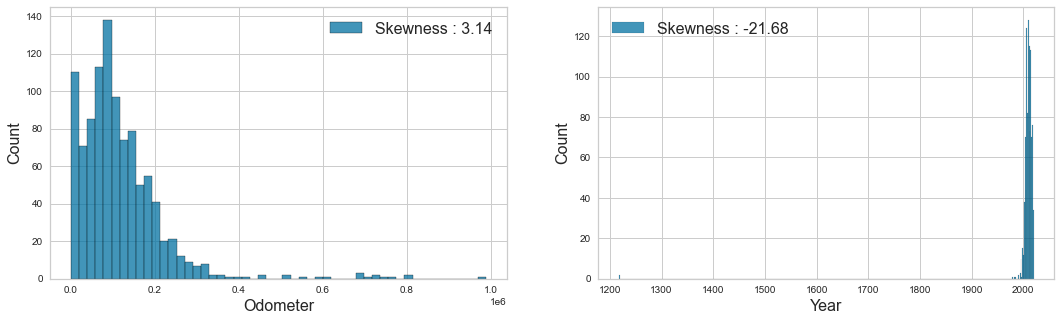

In [168]:
# outlier

fig, ax = plt.subplots(1, 2, figsize=(18, 5))
g = sns.histplot(df_train['odometer'], color='b', label='Skewness : {:.2f}'.format(df_train['odometer'].skew()), ax=ax[0])
g.legend(loc='best', prop={'size':16})
g.set_xlabel('Odometer', fontsize=16)
g.set_ylabel('Count', fontsize=16)

g = sns.histplot(df_train['year'], color='b', label='Skewness : {:.2f}'.format(df_train['year'].skew()), ax=ax[1])
g.legend(loc='best', prop={'size':16})
g.set_xlabel('Year', fontsize=16)
g.set_ylabel('Count', fontsize=16)
plt.show()

In [8]:
numeric_describe = train.describe().loc[:,['odometer', 'year']]
outlier_idx = []
for col in ['odometer', 'year']:
    Q1 = numeric_describe.loc['25%', col]
    Q3 = numeric_describe.loc['75%', col]
    IQR = Q3-Q1
    outlier_list = df_train[(df_train[col] < Q1 - IQR*1.5) | (df_train[col] > Q3 + IQR * 1.5)].index
    outlier_idx.extend(outlier_list)
    
len(outlier_idx)

44

In [9]:
train_df = df_train.drop(outlier_idx, axis=0).reset_index(drop=True)
train_df

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000
...,...,...,...,...,...,...,...,...,...,...,...
970,1010,Toyota Corolla,46768,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Black,2014,5415000
971,1011,Toyota Camry,31600,Abuja,Foreign Used,4-cylinder(I4),automatic,petrol,Silver,2011,3615000
972,1012,Toyota Camry,96802,Abuja,Foreign Used,4-cylinder(I4),automatic,petrol,Black,2011,3415000
973,1013,Lexus GX 460,146275,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Gold,2013,14315000


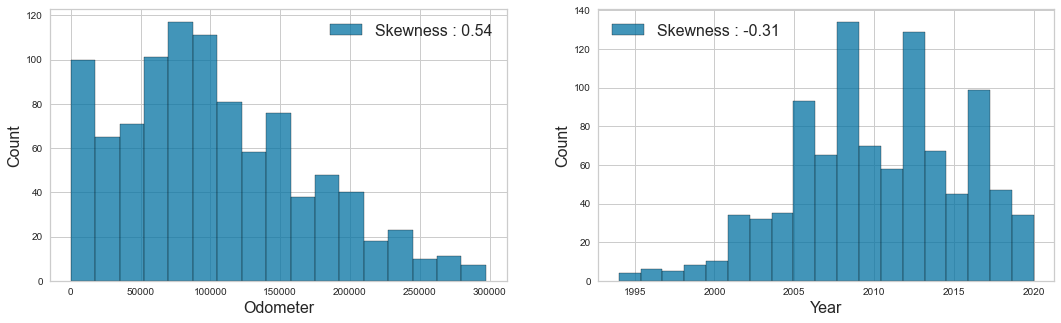

In [171]:
# After remove the outlier

fig, ax = plt.subplots(1, 2, figsize=(18, 5))
g = sns.histplot(train_df['odometer'], color='b', label='Skewness : {:.2f}'.format(train_df['odometer'].skew()), ax=ax[0])
g.legend(loc='best', prop={'size':16})
g.set_xlabel('Odometer', fontsize=16)
g.set_ylabel('Count', fontsize=16)

g = sns.histplot(train_df['year'], color='b', label='Skewness : {:.2f}'.format(train_df['year'].skew()), ax=ax[1])
g.legend(loc='best', prop={'size':16})
g.set_xlabel('Year', fontsize=16)
g.set_ylabel('Count', fontsize=16)
plt.show()

In [11]:
categorical_columns = train.describe(include='object').columns
la_train = train.copy()

for col in categorical_columns:
    encoder = LabelEncoder()
    print(encoder.fit_transform(la_train[col]))
    la_train[col] = encoder.fit_transform(la_train[col])



[180 177  70 ... 169  79  20]
[8 7 7 ... 2 7 7]
[0 2 0 ... 0 0 1]
[3 3 6 ... 3 6 6]
[0 0 0 ... 0 0 1]
[1 1 1 ... 1 1 0]
[51  6 51 ...  6 29 73]


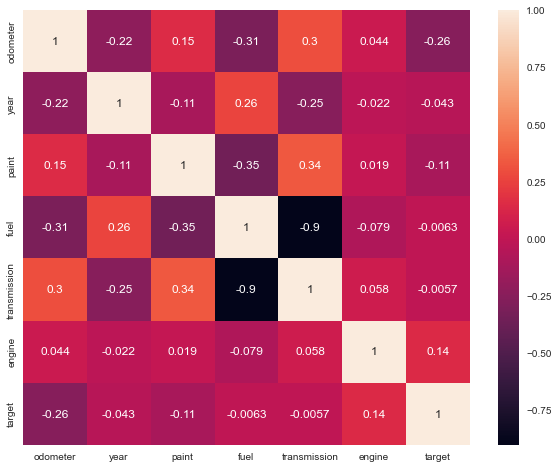

In [12]:
plt.figure(figsize = (10,8))
sns.heatmap(la_train[['odometer', 'year', 'paint', 'fuel', 'transmission', 'engine', 'target']].corr(), annot=True)
plt.show()

In [174]:
# Feature Engineering

print(train_df.title.unique())

['Toyota RAV 4' 'Toyota Land Cruiser' 'Land Rover Range Rover Evoque'
 'Lexus ES 350' 'Toyota Venza' 'Toyota Corolla'
 'Land Rover Range Rover Sport' 'Pontiac Vibe' 'Toyota Tacoma'
 'Lexus RX 350' 'Ford Escape' 'Honda Civic' 'Volvo XC90' 'BMW 750'
 'Infiniti JX' 'Honda Accord' 'Mercedes-Benz ML 350' 'Toyota Camry'
 'Hyundai Azera' 'Lexus GX 460' 'BMW 325' 'Toyota Sienna' 'Honda Fit'
 'Honda CR-V' 'Hyundai Tucson' 'Jaguar XJ8' 'BMW X6' 'Mercedes-Benz C 300'
 'Mitsubishi Galant' 'Mercedes-Benz GL 450' 'Lexus RX 300'
 'Toyota Highlander' 'Mitsubishi CANTER PICK UP' 'Nissan Titan'
 'Lexus IS 250' 'Mercedes-Benz 200' 'Toyota Sequoia' 'Ford Explorer'
 'Hyundai ix35' 'Lexus CT 200h' 'Lexus LX 570' 'Toyota Avensis'
 'Toyota 4-Runner' 'Mercedes-Benz GLE 350' 'Mercedes-Benz E 300'
 'Toyota Avalon' 'Chevrolet Camaro' 'Land Rover Range Rover' 'Mazda CX-9'
 'Lexus RX 330' 'Lincoln Mark' 'Kia Optima' 'Lexus GS 300' 'Jaguar X-Type'
 'Nissan Altima' 'Acura MDX' 'DAF 95XF TRACTOR HEAD' 'Man TGA 18.360'

In [13]:
train_df['company'] = train_df['title'].apply(lambda x:x.split(" ")[0])
df_test['company'] = df_test['title'].apply(lambda x:x.split(" ")[0])

print(len(train_df['company'].unique()))
print(len(df_test['company'].unique()))

39
28


<Axes.ArtistList of 39 patches>
39


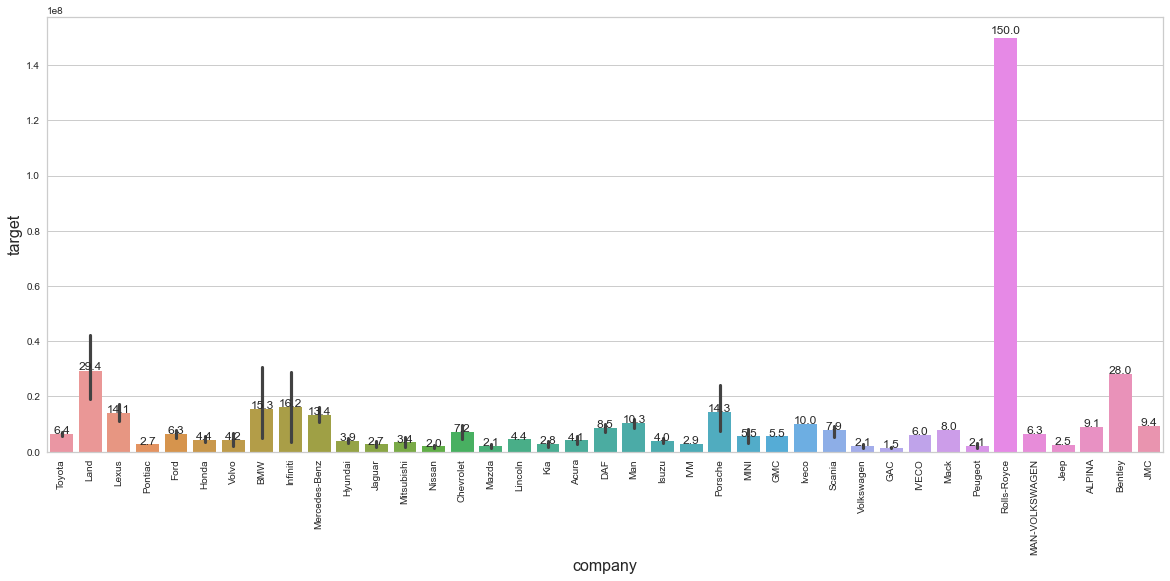

In [14]:
plt.figure(figsize=(20,8))
g = sns.barplot(x='company', y='target', data=train_df)
print(g.patches)
print(len(g.patches))
for p in g.patches:
    left, bottom, width, height = p.get_bbox().bounds
    g.annotate("%.1f"%(height/1e6), (left+width/2, height*1.01), ha='center')

g.set_xlabel("company", fontsize=16)
g.set_ylabel("target", fontsize=16)

plt.xticks(rotation=90)
plt.show()

In [15]:
company_h = np.zeros(len(g.patches))
i = 0
for p in g.patches:
    left, bottom, width, height = p.get_bbox().bounds
    company_h[i] = (height/1e6)
    i +=1    

In [16]:
company_h

array([  6.37849032,  29.39868421,  14.08227273,   2.715     ,
         6.31845588,   4.39417308,   4.15571429,  15.279     ,
        16.16      ,  13.37352941,   3.89282609,   2.665     ,
         3.42      ,   1.98666667,   7.233     ,   2.07875   ,
         4.415     ,   2.81785714,   4.082     ,   8.515     ,
        10.265     ,   4.015     ,   2.89      ,  14.265     ,
         5.54      ,   5.515     ,  10.015     ,   7.93      ,
         2.09409091,   1.49      ,   6.015     ,   8.015     ,
         2.125     , 150.015008  ,   6.34      ,   2.515     ,
         9.065     ,  28.015     ,   9.365     ])

In [19]:
companys = train_df['company'].unique()
companys

array(['Toyota', 'Land', 'Lexus', 'Pontiac', 'Ford', 'Honda', 'Volvo',
       'BMW', 'Infiniti', 'Mercedes-Benz', 'Hyundai', 'Jaguar',
       'Mitsubishi', 'Nissan', 'Chevrolet', 'Mazda', 'Lincoln', 'Kia',
       'Acura', 'DAF', 'Man', 'Isuzu', 'IVM', 'Porsche', 'MINI', 'GMC',
       'Iveco', 'Scania', 'Volkswagen', 'GAC', 'IVECO', 'Mack', 'Peugeot',
       'Rolls-Royce', 'MAN-VOLKSWAGEN', 'Jeep', 'ALPINA', 'Bentley',
       'JMC'], dtype=object)

In [17]:
def company_fix(train_df, df, companys):
  only_test_com = list(set(df['company'])-set(train_df['company']))


  if len(only_test_com) != 0:
    for k in range(len(only_test_com)):
      print(only_test_com)
      df.loc[(df['company'] == only_test_com[k]), 'company'] = 1


  for c in range(7):
    if c==6:
      company_ind = companys[np.where(company_h>=c*5)]
    elif c==0:
      company_ind = companys[np.where(company_h<(c+1)*5)]
    else:  
      company_ind = companys[np.where((company_h>=c*5)&(company_h<(c+1)*5))]
    
    for i in range(len(company_ind)):
      df.loc[(df['company'] == company_ind[i]), 'company'] = c+1

In [20]:
copy_train = train_df.copy()
company_fix(copy_train, train_df, companys)


In [21]:
company_fix(copy_train, df_test, companys)

['Fiat']


In [22]:
train_df.company.unique()

array([2, 6, 3, 1, 4, 7], dtype=object)

In [23]:
df_test.company.unique()

array([3, 1, 2, 4, 6, 7], dtype=object)

In [24]:
# paint

print(sorted(train.paint.unique()))

[' Black', ' Black/Red', 'Ash', 'Ash and black', 'BLACK', 'Beige', 'Black', 'Black ', 'Black and silver', 'Black sand pearl', 'Black.', 'Blue', 'Blue ', 'Brown', 'Cream', 'Cream ', 'DARK GREY', 'Dark Ash', 'Dark Blue', 'Dark Green', 'Dark Grey', 'Dark ash', 'Dark blue ', 'Dark gray', 'Dark silver ', 'Deep Blue', 'Deep blue', 'GOLD', 'Gery', 'Gold', 'Gold ', 'Gray', 'Gray ', 'Green', 'Green ', 'Grey', 'Grey ', 'Ink blue', 'Light Gold', 'Light blue', 'Light silver ', 'Magnetic Gray', 'Magnetic Gray Metallic', 'Maroon', 'Midnight Black Metal', 'Milk', 'Navy blue', 'Off white', 'Off white l', 'Pale brown', 'Purple', 'Red', 'Redl', 'SILVER', 'Silver', 'Silver ', 'Silver/grey', 'Sky blue', 'Skye blue', 'Sliver', 'Super White', 'WHITE', 'WINE', 'Whine ', 'White', 'White ', 'White orchild pearl', 'Wine', 'Yellow', 'blue', 'green', 'orange', 'red', 'white', 'white-blue', 'yellow']


In [25]:
def color_handling(x):
    x['paint'] = x['paint'].str.strip()
    x['paint'] = x['paint'].str.lower()
    x['paint'] = x['paint'].str.replace(".","")

color_handling(train_df)
color_handling(df_test)

In [26]:
train_df.paint.unique()

array(['red', 'black', 'gray', 'white', 'blue', 'redl', 'silver',
       'black/red', 'deep blue', 'dark grey', 'brown', 'grey', 'green',
       'purple', 'gold', 'dark blue', 'milk', 'midnight black metal',
       'beige', 'dark ash', 'cream', 'dark gray', 'white orchild pearl',
       'dark green', 'yellow', 'sliver', 'wine', 'white-blue',
       'magnetic gray', 'dark silver', 'silver/grey', 'ink blue',
       'light blue', 'sky blue', 'gery', 'pale brown', 'whine',
       'black and silver', 'light silver', 'black sand pearl',
       'off white', 'ash', 'maroon', 'navy blue', 'super white',
       'ash and black', 'magnetic gray metallic', 'skye blue',
       'off white l'], dtype=object)

In [27]:
def color_fix(x):
  x['paint'] = x['paint'].str.replace("skye blue", "sky blue")

  x['paint'] = x['paint'].str.replace("dark ash", "dark gray")
  x['paint'] = x['paint'].str.replace("dark grey", "dark gray")
  x['paint'] = x['paint'].str.replace("dark silver", "dark gray")
  x['paint'] = x['paint'].str.replace("ash and black", "dark gray")
  x['paint'] = x['paint'].str.replace("black and silver", "dark gray")

  x['paint'] = x['paint'].str.replace("gery", "gray")
  x['paint'] = x['paint'].str.replace("grey", "gray")
  x['paint'] = x['paint'].str.replace("ash", "gray")
  x['paint'] = x['paint'].str.replace("silver/grey", "gray")
  x['paint'] = x['paint'].str.replace("silver/gray", "gray")
  x['paint'] = x['paint'].str.replace("sliver", "gray")
  x['paint'] = x['paint'].str.replace("silver", "gray")

  x['paint'] = x['paint'].str.replace("magnetic gray", "gray")
  x['paint'] = x['paint'].str.replace("gray metallic", "gray")
  x['paint'] = x['paint'].str.replace("magnetic gray metallic", "gray")

  x['paint'] = x['paint'].str.replace("black sand pearl", "black")
  x['paint'] = x['paint'].str.replace("midnight black metal", "black")


  x['paint'] = x['paint'].str.replace("off white l", "white")
  x['paint'] = x['paint'].str.replace("off white", "white")
  x['paint'] = x['paint'].str.replace("super white", "white")
  x['paint'] = x['paint'].str.replace("white orchild pearl", "white")

  x['paint'] = x['paint'].str.replace("redl", "red")
  x['paint'] = x['paint'].str.replace("maroon", "red")
  x['paint'] = x['paint'].str.replace("whine", "wine")

  x['paint'] = x['paint'].str.replace("ink blue", "dark blue")
  x['paint'] = x['paint'].str.replace("deep blue", "dark blue")
  x['paint'] = x['paint'].str.replace("navy blue", "dark blue")

  x['paint'] = x['paint'].str.replace("sky blue", "light blue")
  x['paint'] = x['paint'].str.replace("pale brown", "brown")

  x['paint'] = x['paint'].str.replace("milk", "cream")

color_fix(train_df)
color_fix(df_test)

In [28]:
print(sorted(train_df['paint'].unique()))
print(len(train_df['paint'].unique()))

['beige', 'black', 'black/red', 'blue', 'brown', 'cream', 'dark blue', 'dark gray', 'dark green', 'gold', 'gray', 'green', 'light blue', 'light gray', 'purple', 'red', 'white', 'white-blue', 'wine', 'yellow']
20


In [29]:
train_df['location'].unique()

array(['Lagos ', 'Lagos', 'Abuja', 'Lagos State', 'Ogun', 'FCT', 'Accra',
       'other', 'Abuja ', 'Abia State', 'Adamawa ', 'Abia', 'Ogun State'],
      dtype=object)

In [30]:
def location_fix(x):
    x['location'] = x['location'].str.replace("Lagos ", "Lagos")
    x['location'] = x['location'].str.replace("Lagos State", "Lagos")
    x['location'] = x['location'].str.replace("Ogun State", "Ogun")
    x['location'] = x['location'].str.replace("Abuja ", "Abuja")
    x['location'] = x['location'].str.replace("Abia State", "Abia")
    x['location'] = x['location'].str.replace("LagosState", "Lagos")


location_fix(train_df)
location_fix(df_test)

In [31]:
print(sorted(train_df['location'].unique()))
print(len(train_df['location'].unique()))

['Abia', 'Abuja', 'Accra', 'Adamawa ', 'FCT', 'Lagos', 'Ogun', 'other']
8


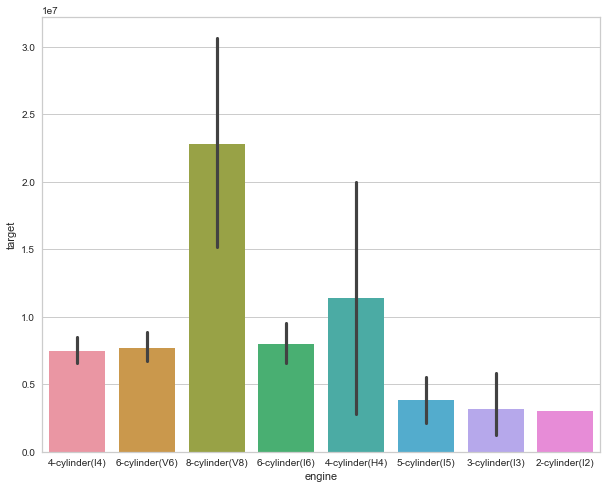

In [193]:
plt.figure(figsize = (10,8))
sns.barplot(x = 'engine', y = 'target', data = train_df)
plt.show()

In [32]:
def engine_fix(df):
    df.loc[~df['engine'].isin(["8-cylinder(V8)" , "4-cylinder(H4)" , "6-cylinder(I6)" , "6-cylinder(V6)" , "4-cylinder(I4)" , "5-cylinder(I5)" , "3-cylinder(I3)" , "2-cylinder(I2)"]), 'engine'] = 2
    df.loc[(df['engine'] == "8-cylinder(V8)"), 'engine'] = 4
    df.loc[(df['engine'] == "4-cylinder(H4)"), 'engine'] = 3
    df.loc[(df['engine'].isin(["6-cylinder(I6)" , "6-cylinder(V6)" , "4-cylinder(I4)"])), 'engine'] = 2
    df.loc[(df['engine'].isin(["5-cylinder(I5)", "3-cylinder(I3)", "2-cylinder(I2)"])), 'engine'] = 1

engine_fix(train_df)
engine_fix(df_test)


In [33]:
print(train_df.engine.unique())
print(df_test.engine.unique())
train_df.head()

[2 4 3 1]
[2 4 1]


,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,company
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,2,automatic,petrol,red,2016,13665000,2
1,1,Toyota Land Cruiser,10,Lagos,New,2,automatic,petrol,black,2019,33015000,2
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,2,automatic,petrol,red,2012,9915000,6
3,3,Lexus ES 350,91524,Lagos,Foreign Used,2,automatic,petrol,gray,2007,3815000,3
4,4,Toyota Venza,94177,Lagos,Foreign Used,2,automatic,petrol,red,2010,7385000,2


In [34]:
categorical_columns = ['title', 'location', 'isimported', 'transmission', 'fuel', 'paint']

for col in categorical_columns:
    print(col)
    print(train_df[col].unique())
    print("Number of columns types : {}".format(len(train_df[col].unique())))
    print()

title
['Toyota RAV 4' 'Toyota Land Cruiser' 'Land Rover Range Rover Evoque'
 'Lexus ES 350' 'Toyota Venza' 'Toyota Corolla'
 'Land Rover Range Rover Sport' 'Pontiac Vibe' 'Toyota Tacoma'
 'Lexus RX 350' 'Ford Escape' 'Honda Civic' 'Volvo XC90' 'BMW 750'
 'Infiniti JX' 'Honda Accord' 'Mercedes-Benz ML 350' 'Toyota Camry'
 'Hyundai Azera' 'Lexus GX 460' 'BMW 325' 'Toyota Sienna' 'Honda Fit'
 'Honda CR-V' 'Hyundai Tucson' 'Jaguar XJ8' 'BMW X6' 'Mercedes-Benz C 300'
 'Mitsubishi Galant' 'Mercedes-Benz GL 450' 'Lexus RX 300'
 'Toyota Highlander' 'Mitsubishi CANTER PICK UP' 'Nissan Titan'
 'Lexus IS 250' 'Mercedes-Benz 200' 'Toyota Sequoia' 'Ford Explorer'
 'Hyundai ix35' 'Lexus CT 200h' 'Lexus LX 570' 'Toyota Avensis'
 'Toyota 4-Runner' 'Mercedes-Benz GLE 350' 'Mercedes-Benz E 300'
 'Toyota Avalon' 'Chevrolet Camaro' 'Land Rover Range Rover' 'Mazda CX-9'
 'Lexus RX 330' 'Lincoln Mark' 'Kia Optima' 'Lexus GS 300' 'Jaguar X-Type'
 'Nissan Altima' 'Acura MDX' 'DAF 95XF TRACTOR HEAD' 'Man TGA 1

In [204]:
for col in categorical_columns:
    print(col)
    print(df_test[col].unique())
    print("Number of columns types : {}".format(len(df_test[col].unique())))
    print()

title
['Mercedes-Benz C 300' 'Honda Accord' 'Mercedes-Benz S 550'
 'Toyota Sienna' 'Toyota Hiace' 'Toyota Corolla' 'Iveco EUROCARGO 120e18'
 'Mercedes-Benz GLE 350' 'Toyota Highlander' 'Toyota Hilux' 'Toyota Camry'
 'Mercedes-Benz C 180' 'Lexus ES 350' 'Honda Fit' 'Toyota Matrix'
 'Toyota Venza' 'Lexus IS 250' 'Nissan Primera' 'Volkswagen Sharan'
 'Jeep Wrangler' 'Volkswagen Golf' 'Mercedes-Benz 814' 'Nissan Sentra'
 'Volkswagen Passat' 'Mercedes-Benz GLK 350' 'Lexus RX 350' 'Ford Mondeo'
 'BMW X3' 'Mack CXN613 CAB BEHIND ENGINE' 'Toyota RAV 4'
 'Land Rover Discovery' 'Toyota Avalon' 'Lexus GX 460' 'Hyundai Santa Fe'
 'Peugeot 206' 'Volvo FL7' 'Mercedes-Benz C 320' 'Hyundai Sonata'
 'Infiniti FX' 'Honda Civic' 'Mercedes-Benz CLS 500'
 'Mercedes-Benz GLK 300' 'Acura RDX' 'Mercedes-Benz G 550' 'BMW 535'
 'Acura TL' 'Nissan Xterra' 'Land Rover Range Rover' 'Nissan A'
 'Toyota 4-Runner' 'Honda Pilot' 'Man LE 8. 180 PLATFORM TRUCK'
 'Toyota Yaris' 'Hyundai Elantra' 'Volvo S80' 'Mercedes-Ben

In [35]:
# Onehot test (순서정보가 필요한가)

train_data = train_df.copy()
test_data = df_test.copy()

for i in range(len(categorical_columns)):
  onehot_encoder = OneHotEncoder(handle_unknown="ignore", sparse = False)

  transformed = onehot_encoder.fit_transform(train_data[categorical_columns[i]].to_numpy().reshape(-1, 1))
  onehot_df = pd.DataFrame(transformed, columns=onehot_encoder.get_feature_names())
  train_data = pd.concat([train_data, onehot_df], axis=1).drop(categorical_columns[i], axis=1)

  test_transformed = onehot_encoder.transform(test_data[categorical_columns[i]].to_numpy().reshape(-1, 1))
  test_onehot_df = pd.DataFrame(test_transformed, columns=onehot_encoder.get_feature_names())
  test_data = pd.concat([test_data, test_onehot_df], axis=1).drop(categorical_columns[i], axis=1)

In [36]:
print(train_data.columns)
print(test_data.columns)
g = sns.histplot(df_train['odometer'], color='b', label='Skewness : {:.2f}'.format(df_train['odometer'].skew()), ax=ax[0])
g.legend(loc='best', prop={'size':16})
g.set_xlabel('Odometer', fontsize=16)
g.set_ylabel('Count', fontsize=16)

Index(['id', 'odometer', 'engine', 'year', 'target', 'company', 'x0_ALPINA B3',
       'x0_Acura MDX', 'x0_Acura RDX', 'x0_Acura TL',
       ...
       'x0_gray', 'x0_green', 'x0_light blue', 'x0_light gray', 'x0_purple',
       'x0_red', 'x0_white', 'x0_white-blue', 'x0_wine', 'x0_yellow'],
      dtype='object', length=226)
Index(['id', 'odometer', 'engine', 'year', 'company', 'x0_ALPINA B3',
       'x0_Acura MDX', 'x0_Acura RDX', 'x0_Acura TL', 'x0_Acura ZDX',
       ...
       'x0_gray', 'x0_green', 'x0_light blue', 'x0_light gray', 'x0_purple',
       'x0_red', 'x0_white', 'x0_white-blue', 'x0_wine', 'x0_yellow'],
      dtype='object', length=225)


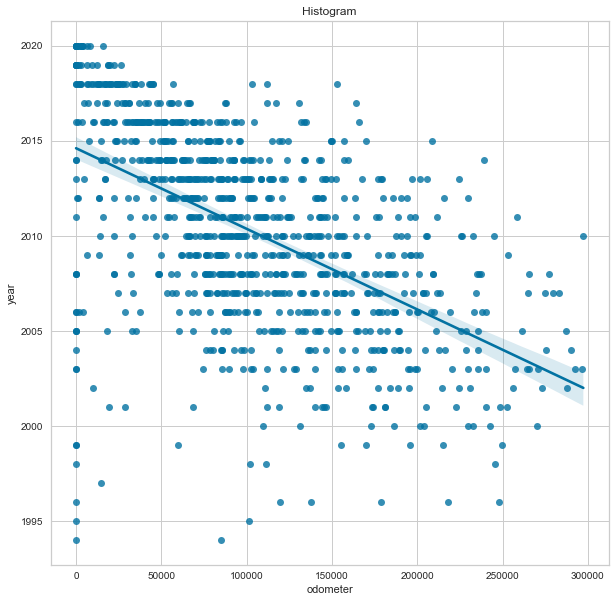

In [84]:
plt.figure(figsize=(10,10))

g = sns.regplot(train_data['odometer'], train_data['year'], color='b')
plt.title("Histogram")
plt.show()


In [110]:
test_data[(test_data.year >= 2022) | (test_data.year < 1500)]

test_data.loc[[304,406],'year'] = int(test_data.year.mean())


In [113]:
# odometer & year 파생변수

def odometer_year_var(df):

    condition_list = [
        (df.year <= 2010) & (df.odometer == 0),
        (df.odometer < 130000) & (df.year <= 2003),
        (df.odometer >=150000) & (df.year > 2015),
        (df.odometer >=230000) & (df.year > 2012)
    ]

    choice_list = [0,0,0,0]

    df['odometer_year'] = np.select(condition_list, choice_list, default=1)


odometer_year_var(train_data)
odometer_year_var(test_data)


In [121]:
train_x = train_data.drop(['id','odometer_range'],axis=1)
test_x = test_data.drop(['id', 'odometer_range'], axis=1)

In [122]:
py_reg = setup(train_x, target='target', session_id=42, silent=True)

,Description,Value
0,session_id,42
1,Target,target
2,Original Data,"(975, 226)"
3,Missing Values,False
4,Numeric Features,35
5,Categorical Features,190
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(682, 228)"


In [123]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,1988095.9458,29854375861075.5078,4722421.2107,0.7909,0.3559,0.2686,1.1800
xgboost,Extreme Gradient Boosting,2103783.1530,28085247222998.4609,4782920.5192,0.7762,0.4153,0.2754,0.2210
rf,Random Forest Regressor,2095130.2323,30473060738548.5898,4887031.5517,0.7536,0.3468,0.2549,0.1480
gbr,Gradient Boosting Regressor,2211743.8625,31007716160512.9609,4930120.1192,0.7524,0.3974,0.3440,0.0480
et,Extra Trees Regressor,2126188.1211,33165182183317.4062,5147308.1391,0.7410,0.3488,0.2463,0.1530
ridge,Ridge Regression,3438405.9002,43137500958829.0156,6005598.1020,0.6515,0.7945,0.9197,0.0090
dt,Decision Tree Regressor,2562377.9305,37733849231942.6719,5749032.5484,0.6469,0.4412,0.3075,0.0100
omp,Orthogonal Matching Pursuit,3243795.0808,44674318631665.8984,6143626.8233,0.6321,0.8143,0.7723,0.0090
lasso,Lasso Regression,3482002.1436,46370518099936.0781,6239944.4293,0.6217,0.8226,0.9204,0.0210
lightgbm,Light Gradient Boosting Machine,3166018.8635,41013040062519.9453,6048194.5538,0.6187,0.5277,0.4665,0.0330


In [117]:
train_x.head()

,odometer,engine,year,target,company,x0_ALPINA B3,x0_Acura MDX,x0_Acura RDX,x0_Acura TL,x0_Acura ZDX,...,x0_light blue,x0_light gray,x0_purple,x0_red,x0_white,x0_white-blue,x0_wine,x0_yellow,odometer_range,odometer_year
0,18277,2,2016,13665000,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4,1
1,10,2,2019,33015000,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1
2,83091,2,2012,9915000,6,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3,1
3,91524,2,2007,3815000,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1
4,94177,2,2010,7385000,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3,1


In [124]:
catboost = create_model('catboost')
xgboost = create_model('xgboost')
rf = create_model('rf')

blended_model = blend_models(estimator_list=[catboost, xgboost, rf])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3353981.3250,114268314522944.2969,10689635.8461,0.6337,0.3585,0.2882
1,1308150.8674,6301266155491.1426,2510232.2911,0.8881,0.2866,0.2218
2,1482606.4661,6383621757634.1836,2526583.0201,0.8515,0.2843,0.2297
3,1128511.3366,5150946053807.0205,2269569.5746,0.7724,0.2890,0.2313
4,2394026.0028,27536948067501.5156,5247565.9184,0.6396,0.3477,0.2819
5,3097712.3236,60791634489871.3125,7796899.0304,0.5920,0.3540,0.2446
6,1641901.2288,16957405634240.9531,4117937.0605,0.8479,0.2668,0.2075
7,1629693.7892,18168013228526.1523,4262395.2455,0.8945,0.3069,0.2318
8,1840143.0990,13904642824774.8438,3728892.9758,0.8830,0.3728,0.2561


In [125]:
final_model = finalize_model(blended_model)
predict = predict_model(final_model, data=test_x)
predict

,odometer,engine,year,company,x0_ALPINA B3,x0_Acura MDX,x0_Acura RDX,x0_Acura TL,x0_Acura ZDX,x0_BMW 325,...,x0_light blue,x0_light gray,x0_purple,x0_red,x0_white,x0_white-blue,x0_wine,x0_yellow,odometer_year,Label
0,1234,2,2017,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1.835727e+07
1,29938,2,2013,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,4.845568e+06
2,87501,2,2012,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,7.341424e+06
3,180894,2,2001,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.284829e+06
4,104814,2,2000,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,2.838087e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,78175,2,2014,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.076977e+07
432,129223,2,2011,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,3.967729e+06
433,100943,2,2013,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.025275e+07
434,81463,2,2003,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3.300620e+06


위쪽 결과가 쵲오

In [227]:
catboost = create_model('catboost')
xgboost = create_model('xgboost')
rf = create_model('rf')

blended_model = blend_models(estimator_list=[catboost, xgboost, rf])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3364166.0359,108300330306001.1875,10406744.4624,0.6528,0.4124,0.3364
1,1364541.8874,6669065475834.8398,2582453.3831,0.8816,0.2981,0.2327
2,1565446.8655,7703065606534.9219,2775439.7141,0.8208,0.3799,0.2502
3,1168147.7976,5540892816034.0439,2353910.1121,0.7552,0.3098,0.2428
4,2428918.2349,27897301811657.1055,5281789.6410,0.6348,0.3805,0.3094
5,3121187.5295,59255321039872.1953,7697747.7901,0.6023,0.3870,0.2564
6,1541285.8789,15203828953820.9434,3899208.7600,0.8636,0.2558,0.2059
7,1645008.7133,17749356936676.5117,4212998.5683,0.8970,0.3249,0.2505
8,1808922.9917,13431228243635.9590,3664864.0143,0.8870,0.3343,0.2478


In [228]:
final_model = finalize_model(blended_model)
predict = predict_model(final_model, data=test_x)
predict

,odometer,engine,year,company,x0_ALPINA B3,x0_Acura MDX,x0_Acura RDX,x0_Acura TL,x0_Acura ZDX,x0_BMW 325,...,x0_green,x0_light blue,x0_light gray,x0_purple,x0_red,x0_white,x0_white-blue,x0_wine,x0_yellow,Label
0,1234,2,2017,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.745828e+07
1,29938,2,2013,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.793997e+06
2,87501,2,2012,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.364403e+06
3,180894,2,2001,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.390534e+06
4,104814,2,2000,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.988074e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,78175,2,2014,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.067186e+07
432,129223,2,2011,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.880724e+06
433,100943,2,2013,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.004180e+07
434,81463,2,2003,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.498933e+06


In [126]:
submission = pd.read_csv("./data/sample_submission.csv")
pred = predict['Label']
submission['target'] = pred

submission.to_csv("./data/pycaret_final.csv", index=False)